In [45]:
# Import required libraries
import pandas as pd
import numpy as np
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sys.path.append(os.path.abspath('../src'))
path_to_py = os.path.abspath('../src')

In [46]:
# Load the cleaned dataset
df = pd.read_csv(os.path.join(path_to_py, "data", "cleaned_train.csv"))

# Initial check
print("Dataset shape:", df.shape)
print("\nFeature names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)

Dataset shape: (189457, 23)

Feature names: ['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'purpose', 'percent_bc_gt_75', 'bc_util', 'dti', 'inq_last_6mths', 'mths_since_recent_inq', 'revol_util', 'total_bc_limit', 'mths_since_last_major_derog', 'tot_hi_cred_lim', 'tot_cur_bal', 'internal_score', 'bad_flag', 'no_credit_card_history', 'no_derog_history', 'credit_limit_group', 'emp_length_missing']

Data types:
 loan_amnt                        int64
term                            object
int_rate                       float64
emp_length                     float64
home_ownership                  object
annual_inc                     float64
purpose                         object
percent_bc_gt_75               float64
bc_util                        float64
dti                            float64
inq_last_6mths                 float64
mths_since_recent_inq          float64
revol_util                     float64
total_bc_limit                 float64
mths_si

## Categorical Feature Encoding

Based on our EDA:
- Home ownership: Ordinal encoding based on default rates
    - MORTGAGE (5.83%) -> 0
    - OWN (7%) -> 1
    - RENT (8.4%) -> 2
    - NONE (9.5%) -> 3
    - OTHER (10.87%) -> 4

- Loan Purpose: Risk-based groupings then encode
    - Low risk (credit_card, home_improvement) -> 0
    - Medium risk (debt_consolidation, car, major_purchase) -> 1
    - High risk (small_business, renewable_energy) -> 2

- Credit Limit Group: Ordinal encoding (already ordered Q1-Q5 by risk)
    - Q5 (4.73%) -> 0
    - Q4 -> 1
    - Q3 -> 2
    - Q2 -> 3
    - Q1 (9.87%) -> 4

In [47]:
# Home ownership encoding based on default rates (ascending order of risk)
home_ownership_risk = {
    'MORTGAGE': 0,  # 5.83%
    'OWN': 1,      # 7.00%
    'RENT': 2,     # 8.40%
    'NONE': 3,     # 9.50%
    'OTHER': 4     # 10.87%
}

# Credit limit group encoding (already ordered by risk Q5 to Q1)
credit_limit_risk = {
    'Q5': 0,  # 4.73%
    'Q4': 1,  
    'Q3': 2,
    'Q2': 3,
    'Q1': 4   # 9.87%
}

# Loan purpose risk-based grouping and encoding
# First, let's define risk groups based on default rates
low_risk_purpose = ['credit_card', 'home_improvement', 'car', 'major_purchase']
medium_risk_purpose = ['debt_consolidation', 'medical', 'moving', 'vacation', 'house', 'wedding']
high_risk_purpose = ['small_business', 'renewable_energy', 'other']

def encode_purpose(purpose):
    if purpose in low_risk_purpose:
        return 0
    elif purpose in medium_risk_purpose:
        return 1
    else:
        return 2

# Apply encodings
df['home_ownership_encoded'] = df['home_ownership'].map(home_ownership_risk)
df['credit_limit_encoded'] = df['credit_limit_group'].map(credit_limit_risk)
df['purpose_encoded'] = df['purpose'].apply(encode_purpose)

# Binary encoding for term (36 months = 0, 60 months = 1)
df['term_encoded'] = df['term'].apply(lambda x: 0 if '36' in x else 1)

# Drop original categorical columns
df = df.drop(['home_ownership', 'credit_limit_group', 'purpose', 'term'], axis=1)

# Verify encodings
print("\nEncoded features check:")
for col in ['home_ownership_encoded', 'credit_limit_encoded', 'purpose_encoded', 'term_encoded']:
    print(f"\n{col} value counts:")
    print(df[col].value_counts().sort_index())

print("\nUpdated dataset shape:", df.shape)


Encoded features check:

home_ownership_encoded value counts:
home_ownership_encoded
0    97647
1    15573
2    76149
3       42
4       46
Name: count, dtype: int64

credit_limit_encoded value counts:
credit_limit_encoded
0    37892
1    37891
2    37891
3    37891
4    37892
Name: count, dtype: int64

purpose_encoded value counts:
purpose_encoded
0     59436
1    118194
2     11827
Name: count, dtype: int64

term_encoded value counts:
term_encoded
0    144800
1     44657
Name: count, dtype: int64

Updated dataset shape: (189457, 23)


## Train-Val-Test Split

In [48]:
# Step 2: Train-Val-Test Split
# First split into train and temp (test + validation)
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['bad_flag'], random_state=42)
# Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['bad_flag'], random_state=42)

print("Dataset shapes:")
print(f"Train: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

# Verify class distribution in splits
print("\nClass distribution in splits:")
print("Train:", train_df['bad_flag'].value_counts(normalize=True))
print("Validation:", val_df['bad_flag'].value_counts(normalize=True))
print("Test:", test_df['bad_flag'].value_counts(normalize=True))

Dataset shapes:
Train: (113674, 23)
Validation: (37891, 23)
Test: (37892, 23)

Class distribution in splits:
Train: bad_flag
0.0    0.930705
1.0    0.069295
Name: proportion, dtype: float64
Validation: bad_flag
0.0    0.930722
1.0    0.069278
Name: proportion, dtype: float64
Test: bad_flag
0.0    0.930698
1.0    0.069302
Name: proportion, dtype: float64


## Feature Transformations and Feature Engineering
1. Log transformation for right-skewed features
- annual_inc
- loan_amnt

2. Standard scaling for normally distributed features:
- int_rate
- dti
- revol_util
- bc_util

3. Feature Engineering
- Composite utilization feature (from revol_util and bc_util)
- Income-to-loan ratio (using log transformed values)
- Relevant interaction terms based on our EDA insights

**Implementation Strategy**:
1. Apply log transformations to all splits (no fitting required)
2. Fit scalers only on training data, then transform all splits
3. Create engineered features using the properly scaled values
4. Drop original features that have been transformed


In [49]:
# Scaling and Feature Transformations (fit only on training data)

# Log transformations first
for df_ in [train_df, val_df, test_df]:
    df_['log_annual_inc'] = np.log1p(df_['annual_inc'])
    df_['log_loan_amt'] = np.log1p(df_['loan_amnt'])

# Standard scaling
scaler = StandardScaler()
scale_features = [
    'int_rate',
    'dti',
    'revol_util',
    'bc_util',
    'percent_bc_gt_75',
    'inq_last_6mths',
    'mths_since_recent_inq',
    'total_bc_limit',
    'tot_hi_cred_lim',
    'tot_cur_bal'
]

# Fit scaler only on training data
scaler_dict = {}
for feature in scale_features:
    scaler_dict[feature] = StandardScaler()
    train_df[f'{feature}_scaled'] = scaler_dict[feature].fit_transform(train_df[[feature]])
    # Transform validation and test using the scaler fit on training data
    val_df[f'{feature}_scaled'] = scaler_dict[feature].transform(val_df[[feature]])
    test_df[f'{feature}_scaled'] = scaler_dict[feature].transform(test_df[[feature]])

# Feature Engineering (using scaled features)
for df_ in [train_df, val_df, test_df]:
    # Composite utilization
    df_['composite_util'] = (df_['revol_util_scaled'] + df_['bc_util_scaled']) / 2
    
    # Income to loan ratio using log transformed values
    df_['income_to_loan_ratio'] = df_['log_annual_inc'] / df_['log_loan_amt']
    
    # Interest rate * DTI interaction
    df_['int_rate_dti'] = df_['int_rate_scaled'] * df_['dti_scaled']
    
    # Risk score
    df_['risk_score'] = (df_['int_rate_scaled'] + 
                        df_['dti_scaled'] + 
                        df_['composite_util'] - 
                        df_['income_to_loan_ratio'])

# Drop original features that have been transformed
columns_to_drop = scale_features + ['annual_inc', 'loan_amnt', 'revol_util_scaled', 'bc_util_scaled']
train_df = train_df.drop(columns_to_drop, axis=1)
val_df = val_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)

# Verify final shapes and features
print("\nFinal shapes:")
print(f"Train: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

# Check for any missing values
print("\nMissing values in final datasets:")
print("Train:", train_df.isnull().sum().sum())
print("Validation:", val_df.isnull().sum().sum())
print("Test:", test_df.isnull().sum().sum())

# Verify engineered features in training set
print("\nEngineered features summary in training set:")
engineered_features = ['composite_util', 'income_to_loan_ratio', 'int_rate_dti', 'risk_score']
print(train_df[engineered_features].describe())


Final shapes:
Train: (113674, 25)
Validation: (37891, 25)
Test: (37892, 25)

Missing values in final datasets:
Train: 0
Validation: 0
Test: 0

Engineered features summary in training set:
       composite_util  income_to_loan_ratio   int_rate_dti     risk_score
count    1.136740e+05         113674.000000  113674.000000  113674.000000
mean    -1.625184e-17              1.181497       0.145471      -1.181497
std      9.296658e-01              0.080044       1.003382       2.094060
min     -2.392725e+00              1.050047      -5.708540      -7.817079
25%     -6.403359e-01              1.124017      -0.295436      -2.563829
50%      1.401623e-01              1.164238       0.024209      -1.076542
75%      7.518084e-01              1.218051       0.531531       0.307964
max      4.245750e+00              1.766755       6.091625       4.996727


**Strategy for Handling Class Imbalance**:
- Let's calculate class weights based on our training data rather than SMOTE or other resampling techniques which can lead to overfitting.
- The weights will be used later in the loss function when training the neural network model

In [50]:
# Calculate class weights using sklearn's balanced method
from sklearn.utils.class_weight import compute_class_weight

balanced_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['bad_flag']),
    y=train_df['bad_flag']
)
balanced_weights_dict = dict(zip(np.unique(train_df['bad_flag']), balanced_weights))

# Convert to PyTorch tensor for later use
class_weights_tensor = torch.FloatTensor([balanced_weights_dict[0], balanced_weights_dict[1]])

print("Balanced class weights:")
print(balanced_weights_dict)
print("\nClass weights tensor:")
print(class_weights_tensor)

Balanced class weights:
{0.0: 0.5372269535052979, 1.0: 7.215564301129872}

Class weights tensor:
tensor([0.5372, 7.2156])


**Observation**:
The class weights look good! The weights reflect the imbalance in our data:
- Majority class (0.0): weight ≈ 0.54
- Minority class (1.0): weight ≈ 7.22

This means the loss function will weigh errors on the minority class (bad loans) about 13.4 times more heavily than errors on the majority class (good loans), which aligns with our class distribution.

## Pytorch Tensors and Data Loaders

In [51]:
# Create PyTorch Dataset and DataLoader

# First, let's separate features and target for each split
def prepare_features_target(df):
   # Separate target
   y = df['bad_flag'].values
   # Drop target from features
   X = df.drop('bad_flag', axis=1).values
   return X, y

# Prepare data for all splits
X_train, y_train = prepare_features_target(train_df)
X_val, y_val = prepare_features_target(val_df)
X_test, y_test = prepare_features_target(test_df)

# Create PyTorch Dataset class
class LoanDataset(Dataset):
   def __init__(self, X, y):
       self.X = torch.FloatTensor(X)
       self.y = torch.FloatTensor(y)
   
   def __len__(self):
       return len(self.y)
   
   def __getitem__(self, idx):
       return self.X[idx], self.y[idx]

# Create Dataset objects
train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)

# Create DataLoaders
batch_size = 256  # Can be tuned

train_loader = DataLoader(
   train_dataset, 
   batch_size=batch_size, 
   shuffle=True
)

val_loader = DataLoader(
   val_dataset, 
   batch_size=batch_size, 
   shuffle=False
)

test_loader = DataLoader(
   test_dataset, 
   batch_size=batch_size, 
   shuffle=False
)

# Verify the dataloaders
print("Number of features:", X_train.shape[1])
print("\nDataLoader sizes:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify a batch
X_batch, y_batch = next(iter(train_loader))
print("\nBatch shapes:")
print(f"X batch shape: {X_batch.shape}")
print(f"y batch shape: {y_batch.shape}")

Number of features: 24

DataLoader sizes:
Training batches: 445
Validation batches: 149
Test batches: 149

Batch shapes:
X batch shape: torch.Size([256, 24])
y batch shape: torch.Size([256])


## Neural Network Architecture
**Characteristics**:
- Input features: 24
- Binary classification task
- Imbalanced features
- Mix of numerical and encoded categorical features

1. Architecture Design:
    - Input Layer: 24 features with batch normalization
    - First Hidden Layer: 128 neurons
    - Second Hidden Layer: 64 neurons
    - Third Hidden Layer: 32 neurons
    - Output Layer: 1 neuron (binary classification)
    - Total parameters: 14,065 (reasonably sized)

2. Components per hidden layer:
    - Linear transformation
    - Batch normalization
    - ReLU activation
    - Dropout (p=0.3)

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LoanDefaultModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super(LoanDefaultModel, self).__init__()
        
        # Input Layer with Batch Normalization
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # Create layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output Layer
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        # Input normalization
        x = self.input_bn(x)
        
        # Hidden layers
        x = self.hidden_layers(x)
        
        # Output layer with sigmoid activation
        return torch.sigmoid(self.output_layer(x))

# Initialize model
input_dim = 24  # number of features
model = LoanDefaultModel(input_dim)

# Print model architecture
print(model)
print("\nNumber of parameters:", sum(p.numel() for p in model.parameters()))

LoanDefaultModel(
  (input_bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

Number of parameters: 14065


In [55]:
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt

## Training Loop Setup
1. Loss function (Binary Cross Entropy with our class weights)
2. Optimizer (Adam)
3. Learning rate scheduler
4. Training loop with validation
5. Early stopping mechanism

In [56]:
# 1. Set up training components
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Custom Weighted BCE Loss
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self, output, target):
        # Calculate BCE loss
        loss = -self.weights[1] * target * torch.log(output + 1e-7) - \
               self.weights[0] * (1 - target) * torch.log(1 - output + 1e-7)
        return torch.mean(loss)
    
# Initialize loss function with class weights
class_weights = torch.FloatTensor([0.5372, 7.2154]).to(device)
criterion = WeightedBCELoss(class_weights)

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max',      # monitor validation AUROC
    factor=0.5,      # reduce LR by half when plateauing
    patience=3,      # number of epochs to wait before reducing LR
    verbose=True
)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_auroc = None
        self.early_stop = False
        
    def __call__(self, val_auroc):
        if self.best_auroc is None:
            self.best_auroc = val_auroc
        elif val_auroc <= self.best_auroc + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_auroc = val_auroc
            self.counter = 0

# Modify training and validation functions to use device
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for batch_X, batch_y in train_loader:
        # Move batch to device
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend(outputs.cpu().detach().numpy())
        targets.extend(batch_y.cpu().numpy())
    
    # # Calculate metrics
    # auroc = roc_auc_score(targets, predictions)
    # avg_precision = average_precision_score(targets, predictions)
    
    # return total_loss / len(train_loader), auroc, avg_precision

    # Calculate all metrics
    predictions = np.array(predictions)
    targets = np.array(targets)
    binary_preds = (predictions >= 0.5).astype(int)
    
    metrics = {
        'loss': total_loss / len(train_loader),
        'auroc': roc_auc_score(targets, predictions),
        'avg_precision': average_precision_score(targets, predictions),
        'f1': f1_score(targets, binary_preds),
        'classification_report': classification_report(targets, binary_preds)
    }
    
    return metrics

def validate(model, val_loader):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # Move batch to device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    # # Calculate metrics
    # auroc = roc_auc_score(targets, predictions)
    # avg_precision = average_precision_score(targets, predictions)
    
    # return total_loss / len(val_loader), auroc, avg_precision
    # Calculate all metrics
    predictions = np.array(predictions)
    targets = np.array(targets)
    binary_preds = (predictions >= 0.5).astype(int)
    
    metrics = {
        'loss': total_loss / len(val_loader),
        'auroc': roc_auc_score(targets, predictions),
        'avg_precision': average_precision_score(targets, predictions),
        'f1': f1_score(targets, binary_preds),
        'classification_report': classification_report(targets, binary_preds)
    }
    
    return metrics

# Training configuration
n_epochs = 100
early_stopping = EarlyStopping(patience=5)

# # Lists to store metrics
# train_losses = []
# val_losses = []
# train_aurocs = []
# val_aurocs = []

print("Starting training...")
print("Epoch\tTrain Loss\tTrain AUROC\tVal Loss\tVal AUROC")

Using device: cpu
Starting training...
Epoch	Train Loss	Train AUROC	Val Loss	Val AUROC


/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Modified Training Loop

Starting training...
Epoch	Train Loss	Train AUROC	Train F1	Train AP	Val Loss	Val AUROC	Val F1	Val AP
1	0.6256	0.7040	0.1974	0.1482	0.6328	0.6979	0.2004	0.1434

New best model saved with validation AUROC: 0.6979
Classification Report for Best Model:
              precision    recall  f1-score   support

         0.0       0.96      0.62      0.75     35266
         1.0       0.12      0.68      0.20      2625

    accuracy                           0.62     37891
   macro avg       0.54      0.65      0.48     37891
weighted avg       0.90      0.62      0.71     37891

2	0.6244	0.7052	0.1972	0.1463	0.6330	0.6984	0.1975	0.1443

New best model saved with validation AUROC: 0.6984
Classification Report for Best Model:
              precision    recall  f1-score   support

         0.0       0.96      0.61      0.74     35266
         1.0       0.12      0.69      0.20      2625

    accuracy                           0.61     37891
   macro avg       0.54      0.65      0.47     37891
weig

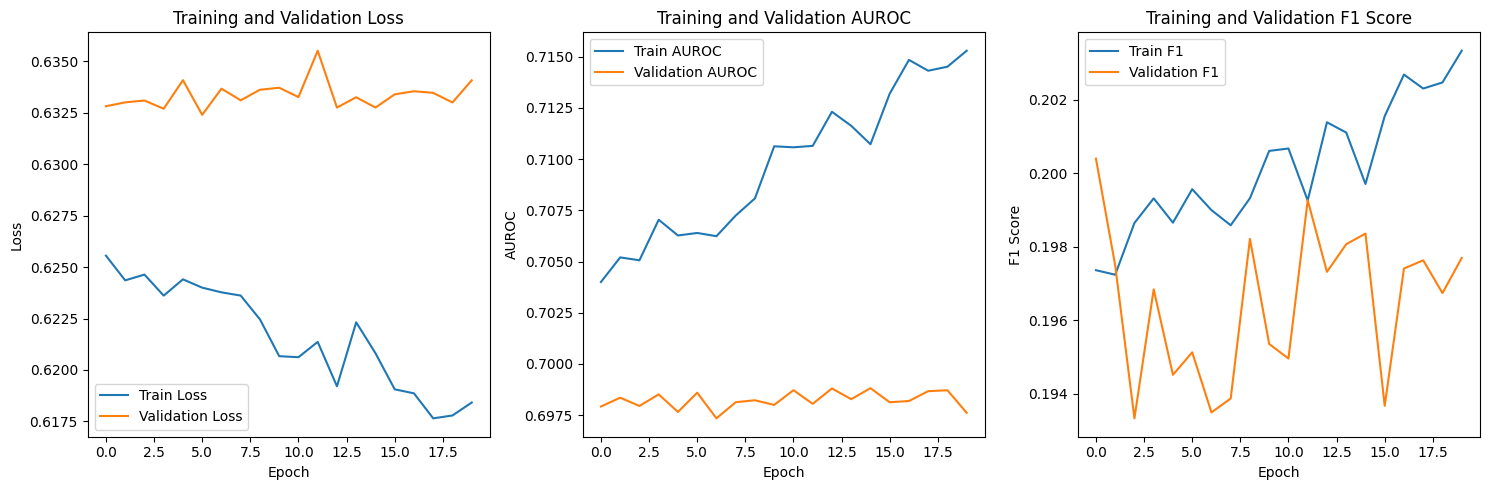

In [57]:
# Main training loop
best_val_auroc = 0
best_model_state = None
early_stopping = EarlyStopping(patience=5)

# Lists to store metrics
train_metrics_history = []
val_metrics_history = []

print("Starting training...")
print("Epoch\tTrain Loss\tTrain AUROC\tTrain F1\tTrain AP\tVal Loss\tVal AUROC\tVal F1\tVal AP")

for epoch in range(n_epochs):
    # Training phase
    train_metrics = train_epoch(model, train_loader, criterion, optimizer)
    
    # Validation phase
    val_metrics = validate(model, val_loader)
    
    # Store metrics
    train_metrics_history.append(train_metrics)
    val_metrics_history.append(val_metrics)
    
    # Print metrics
    print(f"{epoch+1}\t{train_metrics['loss']:.4f}\t{train_metrics['auroc']:.4f}\t"
          f"{train_metrics['f1']:.4f}\t{train_metrics['avg_precision']:.4f}\t"
          f"{val_metrics['loss']:.4f}\t{val_metrics['auroc']:.4f}\t"
          f"{val_metrics['f1']:.4f}\t{val_metrics['avg_precision']:.4f}")
    
    # Print classification report every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\nValidation Classification Report:")
        print(val_metrics['classification_report'])
    
    # Learning rate scheduling
    scheduler.step(val_metrics['auroc'])
    
    # Early stopping
    early_stopping(val_metrics['auroc'])
    
    # Save best model
    if val_metrics['auroc'] > best_val_auroc:
        best_val_auroc = val_metrics['auroc']
        best_model_state = model.state_dict().copy()
        print(f"\nNew best model saved with validation AUROC: {best_val_auroc:.4f}")
        print("Classification Report for Best Model:")
        print(val_metrics['classification_report'])
    
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)

# Plot training curves
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot([m['loss'] for m in train_metrics_history], label='Train Loss')
plt.plot([m['loss'] for m in val_metrics_history], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# AUROC plot
plt.subplot(1, 3, 2)
plt.plot([m['auroc'] for m in train_metrics_history], label='Train AUROC')
plt.plot([m['auroc'] for m in val_metrics_history], label='Validation AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()
plt.title('Training and Validation AUROC')

# F1 Score plot
plt.subplot(1, 3, 3)
plt.plot([m['f1'] for m in train_metrics_history], label='Train F1')
plt.plot([m['f1'] for m in val_metrics_history], label='Validation F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Training and Validation F1 Score')

plt.tight_layout()
plt.show()

### Main Training Loop

1	0.6580	0.6512	0.6453	0.6822
2	0.6476	0.6705	0.6422	0.6858
3	0.6409	0.6801	0.6409	0.6882
4	0.6412	0.6805	0.6412	0.6892
5	0.6424	0.6804	0.6393	0.6909
6	0.6392	0.6830	0.6378	0.6916
7	0.6402	0.6835	0.6370	0.6923
8	0.6386	0.6860	0.6379	0.6924
9	0.6366	0.6870	0.6376	0.6930
10	0.6370	0.6888	0.6360	0.6927
11	0.6358	0.6890	0.6367	0.6927
12	0.6354	0.6891	0.6365	0.6944
13	0.6394	0.6906	0.6362	0.6940
14	0.6343	0.6907	0.6352	0.6942
15	0.6338	0.6920	0.6348	0.6955
16	0.6339	0.6929	0.6365	0.6951
17	0.6344	0.6933	0.6342	0.6963
18	0.6335	0.6925	0.6350	0.6975
19	0.6314	0.6949	0.6355	0.6969
20	0.6302	0.6970	0.6337	0.6972
21	0.6328	0.6971	0.6343	0.6963
22	0.6305	0.6970	0.6335	0.6977
23	0.6306	0.6983	0.6332	0.6966
24	0.6291	0.6989	0.6347	0.6974
25	0.6304	0.6993	0.6347	0.6975
26	0.6285	0.6996	0.6341	0.6981
27	0.6295	0.6999	0.6334	0.6979
28	0.6285	0.7005	0.6324	0.6988
29	0.6280	0.7020	0.6329	0.6986
30	0.6271	0.7016	0.6346	0.6977
31	0.6271	0.7020	0.6322	0.6994
32	0.6282	0.7035	0.6322	0.6977
33	0.6270	0.7030	

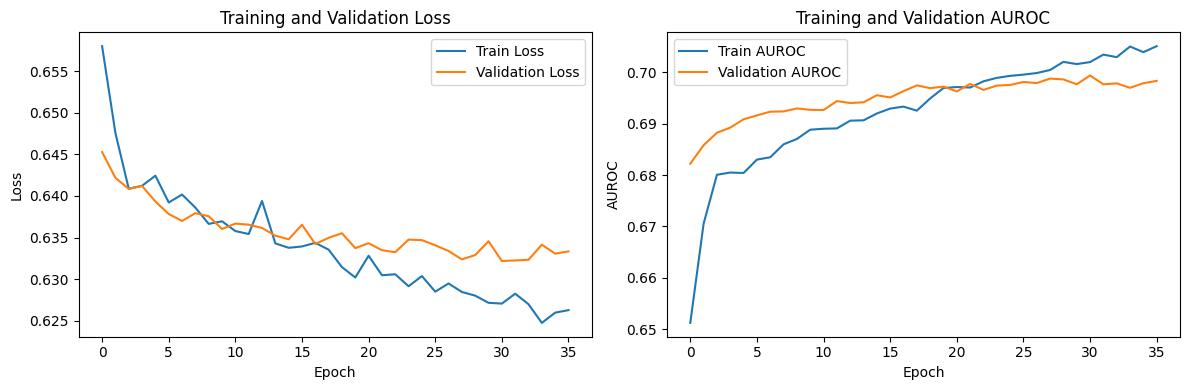

In [54]:
# Main training loop
best_val_auroc = 0
best_model_state = None
# Create fresh early stopping instance
early_stopping = EarlyStopping(patience=5)

# Lists to store metrics
train_metrics_history = []
val_metrics_history = []

print("Starting training...")
print("Epoch\tTrain Loss\tTrain AUROC\tTrain F1\tTrain AP\tVal Loss\tVal AUROC\tVal F1\tVal AP")


for epoch in range(n_epochs):
   # Training phase
   train_loss, train_auroc, train_ap = train_epoch(model, train_loader, criterion, optimizer)
   
   # Validation phase
   val_loss, val_auroc, val_ap = validate(model, val_loader)
   
   # Store metrics
   train_losses.append(train_loss)
   val_losses.append(val_loss)
   train_aurocs.append(train_auroc)
   val_aurocs.append(val_auroc)
   
   # Print metrics
   print(f"{epoch+1}\t{train_loss:.4f}\t{train_auroc:.4f}\t{val_loss:.4f}\t{val_auroc:.4f}")
   
   # Learning rate scheduling
   scheduler.step(val_auroc)
   
   # Early stopping
   early_stopping(val_auroc)
   
   # Save best model
   if val_auroc > best_val_auroc:
       best_val_auroc = val_auroc
       best_model_state = model.state_dict().copy()
   
   if early_stopping.early_stop:
       print(f"Early stopping triggered at epoch {epoch+1}")
       break

# Load best model
model.load_state_dict(best_model_state)

# Print best validation performance
print(f"\nBest validation AUROC: {best_val_auroc:.4f}")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# AUROC plot
plt.subplot(1, 2, 2)
plt.plot(train_aurocs, label='Train AUROC')
plt.plot(val_aurocs, label='Validation AUROC')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()
plt.title('Training and Validation AUROC')

plt.tight_layout()
plt.show()

In [28]:
class LoanDefaultModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[144, 72, 36]):  # Slightly larger
        super(LoanDefaultModel, self).__init__()
        
        # Input Layer with Batch Normalization
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # Create layers with different dropout rates
        layers = []
        prev_dim = input_dim
        
        # Gradually decreasing dropout rates
        dropout_rates = [0.35, 0.25, 0.15]  # Higher at start, lower at end
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rates[i])
            ])
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output Layer
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        x = self.input_bn(x)
        x = self.hidden_layers(x)
        return torch.sigmoid(self.output_layer(x))

# Initialize model
input_dim = 24
model = LoanDefaultModel(input_dim)

print(model)
print("\nNumber of parameters:", sum(p.numel() for p in model.parameters()))

LoanDefaultModel(
  (input_bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden_layers): Sequential(
    (0): Linear(in_features=24, out_features=144, bias=True)
    (1): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.35, inplace=False)
    (4): Linear(in_features=144, out_features=72, bias=True)
    (5): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=72, out_features=36, bias=True)
    (9): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.15, inplace=False)
  )
  (output_layer): Linear(in_features=36, out_features=1, bias=True)
)

Number of parameters: 17257


In [32]:
class LoanDefaultModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 96, 32]):
        super(LoanDefaultModel, self).__init__()
        
        # Input Layer with Batch Normalization
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        layers = []
        prev_dim = input_dim
        
        # Lower dropout rates since we'll add weight decay
        dropout_rates = [0.25, 0.2, 0.15]
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rates[i])
            ])
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        x = self.input_bn(x)
        x = self.hidden_layers(x)
        return torch.sigmoid(self.output_layer(x))

# Initialize model
input_dim = 24
model = LoanDefaultModel(input_dim)
model = model.to(device)

# Modified optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# More aggressive scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.3,  # More aggressive reduction
    patience=2,   # Reduce patience
    verbose=True
)

# Reduce batch size
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [43]:
from imblearn.over_sampling import SMOTE
import numpy as np

# First, apply SMOTE only to training data
print("Original training data shape:", X_train.shape)
print("Original class distribution:", np.bincount(y_train.astype(int)))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nResampled training data shape:", X_train_resampled.shape)
print("Resampled class distribution:", np.bincount(y_train_resampled.astype(int)))

# Create new training dataset and dataloader with resampled data
train_dataset_resampled = LoanDataset(X_train_resampled, y_train_resampled)
train_loader = DataLoader(
    train_dataset_resampled, 
    batch_size=256,  # keeping our smaller batch size
    shuffle=True
)

# Keep the same validation and test loaders
# Keep the same model architecture from our best performing version
class LoanDefaultModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):  # back to our best architecture
        super(LoanDefaultModel, self).__init__()
        
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        x = self.input_bn(x)
        x = self.hidden_layers(x)
        return torch.sigmoid(self.output_layer(x))

# Initialize model and move to device
model = LoanDefaultModel(input_dim=24)
model = model.to(device)

# # Keep class weights (although effect might be less pronounced with balanced data)
# class_weights = torch.FloatTensor([0.5372, 7.2154]).to(device)
# criterion = WeightedBCELoss(class_weights)

# Use regular BCE Loss instead of weighted
criterion = nn.BCELoss()

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)

Original training data shape: (132619, 24)
Original class distribution: [123429   9190]

Resampled training data shape: (246858, 24)
Resampled class distribution: [123429 123429]


/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [41]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, output, target):
        # BCE loss
        bce_loss = -(target * torch.log(output + 1e-7) + (1 - target) * torch.log(1 - output + 1e-7))
        
        # Focal term
        pt = torch.where(target == 1, output, 1 - output)
        focal_term = (1 - pt) ** self.gamma
        
        # Apply alpha weighting
        alpha_weight = torch.where(target == 1, self.alpha, 1 - self.alpha)
        
        focal_loss = alpha_weight * focal_term * bce_loss
        return torch.mean(focal_loss)

# Initialize model with best architecture
model = LoanDefaultModel(input_dim=24)
model = model.to(device)

# Use Focal Loss instead of weighted BCE
criterion = FocalLoss(alpha=0.25, gamma=2.0)

# Rest remains same
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)

/Users/tejovinay/.pyenv/versions/3.10.7/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
